## This is a simulation of the complete system

### Patient's Device

Patient's Id

In [1]:
owner_id = "owner_5"

Get Signal

<Axes: >

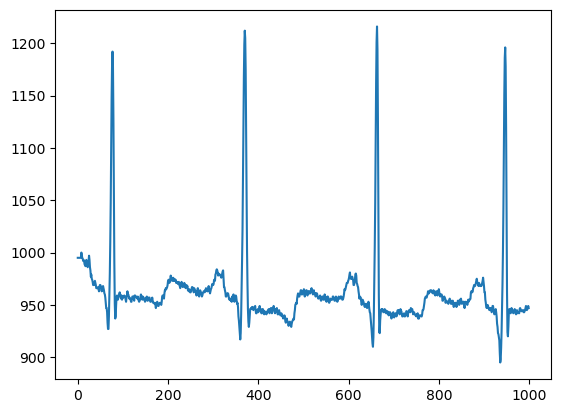

In [2]:
from ECG_Processing_API.data_process.dataProcessor import signal_to_beats
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('ECG_Processing_API/archive/100.csv')
signal = df['\'MLII\''][:1000]

# plot a portion 
signal.plot.line()

load model

In [3]:
import torch
import io
from ECG_Classification.server.train import ecg_net

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ecg_net(2).to(device=device)

# Load the model from the file
model_path = '/home/ifran/TNR Lab/Federated-ECG/ECG_Classification/server/model_round_3.pth'
checkpoint = torch.load(model_path)

# Pre-load the data into a buffer
buffer = io.BytesIO()
torch.save(checkpoint, buffer)
buffer.seek(0)

# Load the model from the buffer
model.load_state_dict(torch.load(buffer))
model.eval()

using cpu device.


ecg_net(
  (model): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv1d(16, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=2944, out_features=500, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=500, out_features=2, bias=True)
  )
)

Extract beats from the signal for diagnosis

In [4]:
import requests
signal_data = signal.values.tolist()

# POST request to ECG-Process API to get beats from signal
url = "http://127.0.0.1:8000/beats_from_signal/"

# The data to post
data = {
  "signal_data": signal_data,
}

# POST signal
API_response = requests.get(url, json = data)

188

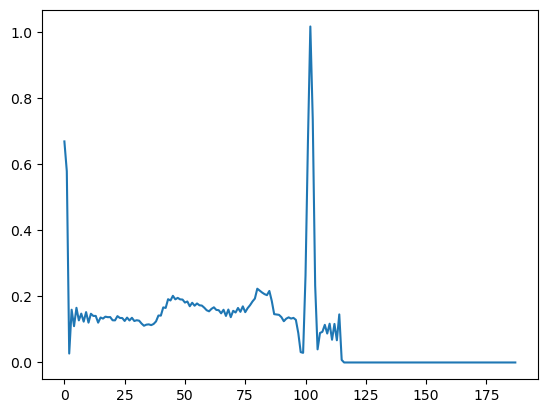

In [5]:
# GET heartbeats
json_data = API_response.json()
beats_json = json_data['beats']
from ECG_Classification.client.data_process.pre_n_post_process import beats_str_to_list

# GET beats and convert beats_json to list
beats = beats_str_to_list(beats_json)

# get a random beat
beat = beats[1]
plt.plot(beat)
len( beat )

In [6]:
# Pass the signal through the model for inference
with torch.no_grad():
    # Convert the beat to a tensor and add an extra dimension
    input_signal = torch.tensor(beat).float().unsqueeze(0)
    
    # Perform the inference
    output = model(input_signal)

import torch.nn.functional as F

# Apply sigmoid activation function to the output probabilities
probabilities = F.sigmoid(output)[0]

# Check if the probability of class 0 is greater than class 1
if probabilities[0] > probabilities[1]:
    annotation = 0
else:
    annotation = 1

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [7]:
is_verified = "False"
# a sample signal count of the patient, will be incremented for each new signal e.g 1,2,3,4,5,6,7,8,9,10
signal_count = 5

generate signal_id <br>
(generated using the owner_id and signal_count) so that it can be easily accesseble from the database)

In [8]:
signal_id = 'signal' + '_' + str(signal_count) + '_'  + str(owner_id) 
signal_id

'signal_5_owner_5'

In [9]:
data =  {'signal': signal_data,
        'beats': beats_json}
str(data)

"{'signal': [995, 995, 995, 995, 995, 995, 995, 995, 1000, 997, 995, 994, 992, 993, 992, 989, 988, 987, 990, 993, 989, 988, 986, 988, 993, 997, 993, 986, 983, 977, 979, 975, 974, 972, 969, 969, 969, 971, 973, 971, 969, 966, 966, 966, 966, 967, 965, 963, 967, 969, 969, 968, 967, 963, 966, 964, 968, 966, 964, 961, 960, 957, 952, 947, 947, 943, 933, 927, 927, 939, 958, 980, 1010, 1048, 1099, 1148, 1180, 1192, 1177, 1128, 1058, 991, 951, 937, 939, 950, 958, 959, 957, 955, 958, 959, 961, 962, 960, 957, 956, 959, 955, 957, 958, 957, 958, 959, 958, 958, 955, 953, 957, 959, 963, 960, 960, 958, 956, 957, 956, 955, 953, 953, 956, 958, 958, 958, 956, 954, 959, 959, 958, 958, 957, 957, 956, 958, 956, 954, 953, 954, 955, 958, 960, 957, 958, 955, 958, 957, 957, 955, 955, 953, 956, 956, 957, 958, 954, 954, 955, 957, 957, 957, 954, 953, 953, 955, 955, 957, 954, 952, 952, 952, 951, 952, 950, 947, 950, 952, 953, 952, 949, 949, 951, 951, 952, 952, 951, 950, 953, 958, 959, 959, 957, 956, 961, 964, 964, 96

create data

In [10]:
signal_info = {
  "id": signal_id,
  "type": "doctor",
  "data": signal_data,
  "beats": beats_json,
  "isVerified": "true",
  "annotation": 1,
  "ownerId": owner_id
}



POST Signal and Beats

In [11]:
import requests

# Define the URL
url = "http://localhost:3210/signals/"

# Send a POST request with the signal_info
response = requests.post(url, json=signal_info)

# Check the response status code
if response.status_code == 200:
    print("Signal info posted successfully.")
else:
    print("Failed to post signal info.")

Signal info posted successfully.


### Doctor's Portal
Doctor's portal will get updated when a new data gets added and doctor will update the annoation if needed as well as update is_verified to True

In [12]:
import requests

# Define the URL
url = "http://localhost:3210/signals/"

# Send a GET request to retrieve the data
response = requests.get(url)

# Check the response status code
if response.status_code == 200:
    data = response.json()
    latest_data = data[-1]  # Get the last element from the data list
    print(latest_data)
else:
    print("Failed to retrieve data.")

{'ID': 'xtz', 'IsVerified': 'true', 'OwnerID': 'ownerId6543647', 'Type': 'doctor', 'annotation': '1', 'beats': '{[1,2,3]}', 'data': '{[1,2,3]}'}


In [13]:
# import requests

# # Define the URL
# url = "http://localhost:3210/signals/"+"123"

# # Send a GET request to retrieve the data
# response = requests.get(url)

# # Check the response status code
# if response.status_code == 200:
#     data = response.json()    
#     # Update the information here
#     data["isVerified"] = True
#     data["annotation"] = 0
    
#     # Send a PUT request to update the data
#     response = requests.put(url, json=latest_data)
#     print(response.status_code)
#     if response.status_code == 200:
#         print("Data updated successfully.")
#     else:
#         print("Failed to update data.")
# else:
#     print("Failed to retrieve data.")


there's a problem with the update operation in blockchain api, for now we pretend the data is updated, which means is_verified = "true"

### patient's device <br>
as the doctor has updated the data now patient device will fetch that signal and beats to proccess

In [18]:
signal_id

'signal_5_owner_5'

In [19]:
# Define the URL
url = "http://localhost:3210/signals/"+signal_id

# Send a GET request to retrieve the data
response = requests.get(url)

problem 2: when we push data, the data in particular can't be pushed

we'll pretend we got the signal_info, need to fix this later

In [25]:
beats_json = response.json()['beats']

In [26]:
from ECG_Classification.client.data_process.pre_n_post_process import beats_str_to_list

beats = beats_str_to_list(beats_json)

In [ ]:
beats

In [23]:
annotation = signal_info['annotation']

update dataset according to annotation

In [27]:
# get annotation for the current signal infereing the existing model
# we assume the annotation for the current signal is 1 (Abnormal)


# choose dataset path according to annotation
if annotation == 0:
    path = "/home/ifran/TNR Lab/Federated-ECG/ECG_Classification/client/datasets/ptbdb_abnormal.csv"
else: 
    path = "/home/ifran/TNR Lab/Federated-ECG/ECG_Classification/client/datasets/ptbdb_normal.csv"

# Create a DataFrame from the list of NumPy arrays
# remove the first and the last beat as they tend to remain incomplete
new_beats = pd.DataFrame(beats[1: (len(beats)-1)])

# Load the existing CSV file
existing_dataset = pd.read_csv(path, header=None)

# Add the DataFrame to the existing DataFrame
new_df = pd.concat([existing_dataset, new_beats], axis=0)

# Write the new DataFrame to the CSV file
new_df.to_csv(path, index=False)